使用设备: cuda:0


d:\MobileEmuMaster\anaconda3\envs\pytorch\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/100 - 总损失: 0.0005751643911935389, 边界损失: 1.5837445971556008e-05, PDE损失: 0.0004639086255338043, 真实数据误差: 9.541828330839053e-05
迭代 1 中的反演参数 a: -0.483472
0|100 总损失=0.0005751643911935389 PDE损失=0.0004639086255338043 真实数据误差=9.541828330839053e-05
Epoch 2/100 - 总损失: 7.072554240039608e-07, 边界损失: 1.4853540619697014e-08, PDE损失: 6.267035814744304e-07, 真实数据误差: 6.569830901526075e-08
迭代 2 中的反演参数 a: 0.005032
1|100 总损失=7.072554240039608e-07 PDE损失=6.267035814744304e-07 真实数据误差=6.569830901526075e-08
Epoch 3/100 - 总损失: 4.704447498227182e-09, 边界损失: 6.02717875608505e-11, PDE损失: 2.8997524381679796e-09, 真实数据误差: 1.744423494542957e-09
迭代 3 中的反演参数 a: 0.007852
2|100 总损失=4.704447498227182e-09 PDE损失=2.8997524381679796e-09 真实数据误差=1.744423494542957e-09
Epoch 4/100 - 总损失: 4.646838469568593e-09, 边界损失: 1.4595702424458068e-10, PDE损失: 3.5390972374926832e-09, 真实数据误差: 9.617839857867239e-10
迭代 4 中的反演参数 a: 0.007881
3|100 总损失=4.646838469568593e-09 PDE损失=3.5390972374926832e-09 真实数据误差=9.617839857867239e-10
Epoch 5/100 - 总损失

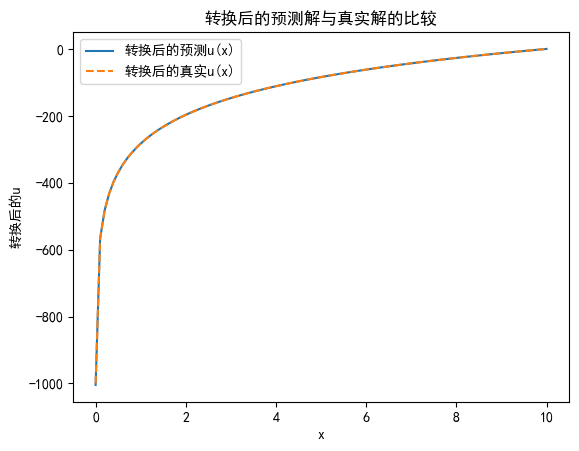

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.utils.parametrizations import weight_norm  # Updated weight normalization
import time
import pickle
from sklearn.metrics import r2_score
import pandas as pd

# Set matplotlib font to support Chinese characters
plt.rcParams['font.family'] = 'SimHei'  # Set font to SimHei for Chinese characters
plt.rcParams['axes.unicode_minus'] = False  # Ensure negative signs are displayed correctly

# -----------------------------
# Function to transform predicted and true values
def transform_values(psi):
    return (1 / 0.008) * torch.log(psi + torch.exp(torch.tensor(-8.0)))

# Forward gradient function (kept unchanged)
def fwd_gradients(Y, x):
    dummy = torch.ones_like(Y)
    G = torch.autograd.grad(Y, x, dummy, create_graph=True)[0]
    return G

# Neural Network class with Xavier initialization and weight normalization
class Net(torch.nn.Module):
    def __init__(self, layer_dim, X, device):
        super().__init__()
        # Normalization parameters
        self.X_mean = torch.from_numpy(X.mean(0, keepdims=True)).float().to(device)
        self.X_std = torch.from_numpy(X.std(0, keepdims=True)).float().to(device)

        self.num_layers = len(layer_dim)
        temp = []
        for l in range(1, self.num_layers):
            linear = weight_norm(torch.nn.Linear(layer_dim[l-1], layer_dim[l]), dim=0)
            torch.nn.init.xavier_uniform_(linear.weight)
            if linear.bias is not None:
                torch.nn.init.zeros_(linear.bias)
            temp.append(linear)
        self.layers = torch.nn.ModuleList(temp)

    def forward(self, x):
        x = (x - self.X_mean) / self.X_std  # Normalize the input
        for i in range(0, self.num_layers-1):
            x = self.layers[i](x)
            if i < self.num_layers-2:
                x = F.silu(x)  # Use the SiLU activation function
        return x

# TSONN class for training and model management
class TSONN():
    def __init__(self, layers, device, true_a=0.01):
        self.layers = layers
        self.device = device

        # Trainable parameter a
        self.a = torch.tensor(true_a, dtype=torch.float32, requires_grad=True, device=device)

        Nx = 101
        x = torch.linspace(0, 10, Nx).to(self.device)
        self.X_ref = x.reshape(-1, 1)

        self.X_lbc = torch.tensor([[0]], device=self.device)
        self.X_ubc = torch.tensor([[10.0]], device=self.device)

        self.Nx = Nx
        self.log = {'losses': [], 'losses_b': [], 'losses_f': [], 'time': []}
        self.min_loss = 1

        # Initialize the model
        self.model = Net(self.layers, self.X_ref.cpu().detach().numpy(), self.device).to(self.device)

        # Ensure a is added to the optimizer
        self.optimizer = torch.optim.LBFGS(
            list(self.model.parameters()) + [self.a],  # Add a to the optimizer parameters
            max_iter=100
        )

    def Mseb(self):
        """Compute the boundary condition loss"""
        pred_lbc = self.model(self.X_lbc)
        pred_ubc = self.model(self.X_ubc)
        mseb = ((pred_lbc - 0) ** 2 + (pred_ubc - (1 - torch.exp(torch.tensor(-8.0)))) ** 2).mean()
        return mseb

    def TimeStepping(self):
        """Time stepping update"""
        X = self.X
        pred = self.model(X)
        u = pred
        self.U0 = u.detach()

    def Msef(self):
        """Compute the PDE residual loss"""
        X = self.X
        pred = self.model(X)
        u = pred
        u_x = fwd_gradients(u, X)
        u_xx = fwd_gradients(u_x, X)
        res = u_x * self.a + u_xx  # Replace a with the trained parameter
        U1 = u
        R1 = res

        dtau = 10  # Time step size
        msef = 1 / dtau ** 2 * ((U1 - self.U0 + dtau * R1) ** 2).mean()
        return msef

    def Loss(self):
        """Compute the total loss"""
        mseb = self.Mseb()
        msef = self.Msef()
        # Add error with respect to the true data psi
        psi_pred = self.model(self.X_ref)
        psi_error = torch.mean((psi_pred - self.psi_data_tensor) ** 2)
        loss = mseb + msef + psi_error  # Total loss includes the true data error
        return loss, mseb, msef, psi_error

    def ResidualPoint(self):
        """Generate PDE residual points"""
        self.X = torch.linspace(0, 10, 200, device=self.device).reshape(-1, 1)
        self.X.requires_grad = True

    def train(self, epoch):
        """Train the model"""
        # Load the true data
        file_path = "true_data.xlsx"
        df = pd.read_excel(file_path)
        z_data = df.iloc[:, 0].values.reshape(-1, 1)
        psi_data = df.iloc[:, 2].values.reshape(-1, 1)

        self.psi_data_tensor = torch.tensor(psi_data, dtype=torch.float32).to(self.device)

        if len(self.log['time']) == 0:
            t1 = time.time()
        else:
            t1 = time.time() - self.log['time'][-1]

        for i in range(epoch):
            def closure():
                self.optimizer.zero_grad()
                self.loss, self.loss_b, self.loss_f, self.psi_error = self.Loss()
                self.loss.backward()
                return self.loss

            self.ResidualPoint()
            self.TimeStepping()
            self.optimizer.step(closure)

            if (self.loss != self.loss) or ((i > 1) and (self.loss.item() > 3 * self.log['losses'][-1])):  # Check for NaN or exploding loss
                if i == 0:
                    self.model = Net(self.layers, self.X_ref.cpu().detach().numpy(), self.device).to(self.device)
                    continue
                else:
                    self.model.load_state_dict(torch.load('model_temp.pth'))  # Load model from checkpoint
                    print('Model loaded from checkpoint')
                    self.ResidualPoint()
                    continue

            if i % 3 == 0:
                torch.save(self.model.state_dict(), 'model_temp.pth')  # Save model every 3 iterations

            t2 = time.time()
            self.log['losses'].append(self.loss.item())
            self.log['losses_b'].append(self.loss_b.item())
            self.log['losses_f'].append(self.loss_f.item())
            self.log['time'].append(t2 - t1)

            print(f'Epoch {i + 1}/{epoch} - Total Loss: {self.loss.item()}, Boundary Loss: {self.loss_b.item()}, PDE Loss: {self.loss_f.item()}, True Data Error: {self.psi_error.item()}')
            print(f"Iteration {i + 1} Inverse parameter a: {self.a.item():.6f}")  # Output the a value at each iteration

            if (i % np.clip(int(epoch / 1000), 1, 1000) == 0) or (i == epoch - 1):
                print(f'{i}|{epoch} Total Loss={self.loss.item()} PDE Loss={self.loss_f.item()} True Data Error={self.psi_error.item()}')

# Exact solution function
def func(x):
    a = 0.008
    phi_d = -1000
    x_cpu = x.detach().cpu().numpy()
    term1 = (1 - np.exp(a * phi_d)) * np.exp(a / 2 * (10 - x_cpu))
    sinh_ratio = np.sinh(a * x_cpu / 2) / np.sinh(a * 10 / 2)
    term2 = np.exp(a * phi_d)
    return torch.tensor(term1 * sinh_ratio, dtype=torch.float32)

# -----------------------------
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    layers = [1, 128, 128, 128,  1]
    tsonn = TSONN(layers, device, true_a=0.008)  # Initial guess for a is 0.008
    tsonn.train(100)

    x = tsonn.X_ref.cpu().detach().numpy()
    u_pred = tsonn.model(tsonn.X_ref).cpu().detach().numpy()
    u_exact = func(torch.tensor(x, dtype=torch.float32)).detach().numpy()

    u_pred_transformed = transform_values(torch.tensor(u_pred)).cpu().detach().numpy()
    u_exact_transformed = transform_values(torch.tensor(u_exact)).cpu().detach().numpy()
    u_pred_transformed = u_pred_transformed.flatten()
    u_exact_transformed = u_exact_transformed.flatten()

    r2_transformed = r2_score(u_exact_transformed, u_pred_transformed)
    relative_l2_error_transformed = np.linalg.norm(u_exact_transformed - u_pred_transformed) / np.linalg.norm(u_exact_transformed)

    print(f"R² Score (Transformed): {r2_transformed:.4f}")
    print(f"Relative L2 Error (Transformed): {relative_l2_error_transformed:.4e}")

    data = {
        'z': x.flatten(),
        'Transformed Exact Values': u_exact_transformed,
        'Transformed Predicted Values': u_pred_transformed
    }
    df = pd.DataFrame(data)
    df.to_excel('transformed_predictions.xlsx', index=False)

    # Plotting the results
    plt.plot(x, u_pred_transformed, label='Transformed Predicted u(x)')
    plt.plot(x, u_exact_transformed, label='Transformed Exact u(x)', linestyle='dashed')
    plt.title('Comparison of Transformed Predicted and Exact Solutions')
    plt.xlabel('x')
    plt.ylabel('Transformed u')
    plt.legend()
    plt.show()
